# 15.S04 Final Project

Step 1: Importing the necessary libraries

In [ ]:
import os
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from keras.applications.imagenet_utils import decode_predictions

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# We first need to download and unpack the folder with the images
# This will take 1-2 minutes 
# If you want to download the grayscale version, use https://www.dropbox.com/s/5syy88b3zw01lm8/frames_gray.zip and replace 'frames.zip' by 'frames_gray.zip' 

!wget https://www.dropbox.com/s/5syy88b3zw01lm8/frames_gray.zip 
!unzip -qq "frames_gray.zip"
!rm "frames_gray.zip"

--2022-05-04 05:14:24--  https://www.dropbox.com/s/5syy88b3zw01lm8/frames_gray.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5syy88b3zw01lm8/frames_gray.zip [following]
--2022-05-04 05:14:25--  https://www.dropbox.com/s/raw/5syy88b3zw01lm8/frames_gray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3609528221ca2402cef7f55913.dl.dropboxusercontent.com/cd/0/inline/BklcfoJ5Y4UXTXroF_gcMOpZTO0P8pM8XFYt27QAviQrKPUiC0RIHeauZKAb8wwb2vs6FH7WOshwwcZxcoAt54yh3YLpHzLUmlHcQxOA_NYduC1cvIcIcUfDNVGZp3Ex8Df49CMyKgN1hoJc-D-VqZHs5SHvXqN23rPg74woRCZ-yw/file# [following]
--2022-05-04 05:14:25--  https://uc3609528221ca2402cef7f55913.dl.dropboxusercontent.com/cd/0/inline/BklcfoJ5Y4UXTXroF_gcMOpZTO0P8pM8XFYt27QAviQrKPUiC0RIHeauZKA

Exploratory Data Analysis

In [ ]:
# Let's read our deat in batches of 32

batch_size = 1000

dataset = keras.utils.image_dataset_from_directory(
    'frames_gray', # or 'frames_gray'
    labels=None,
    image_size=(64, 64),
    batch_size=batch_size)

Found 400322 files belonging to 1 classes.


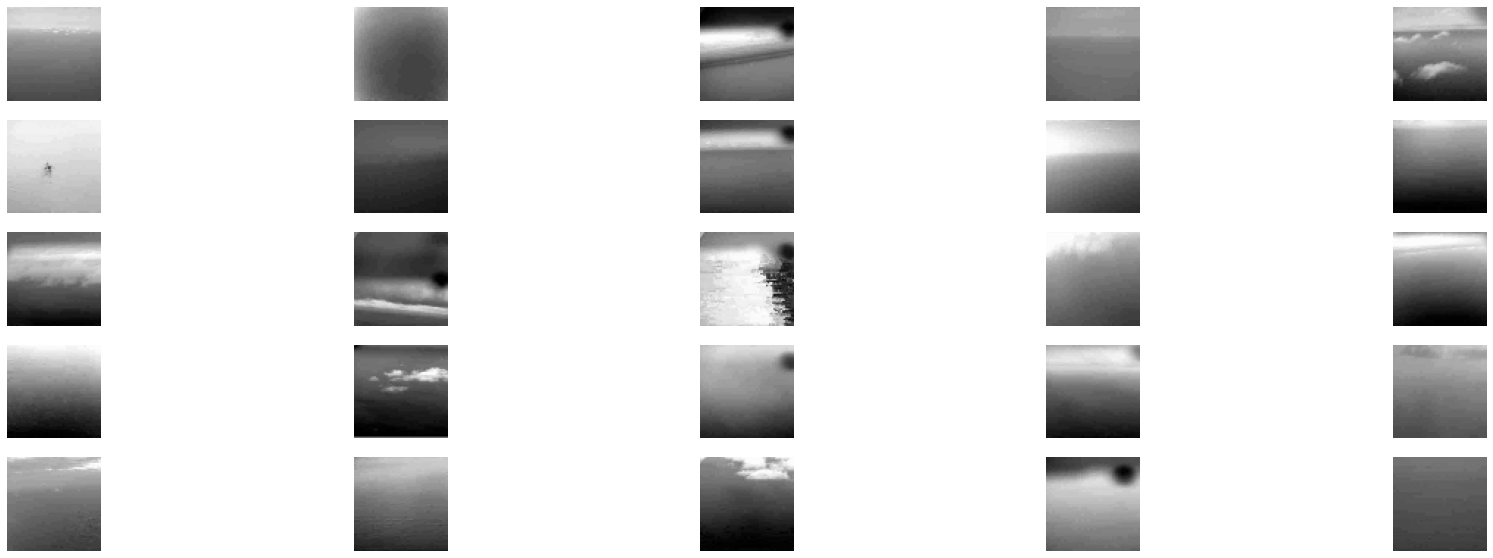

In [ ]:
# Let's look at some of these images
plt.figure(figsize=(30, 10))
t = 0
for images in dataset.take(1):  # This will read 1 batch of data
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.axis("off")
    t +=1 
    if t>25: 
      break

Building the ResNet Network

In [ ]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(64, 64, 3))

94781440/94765736 [==============================] - 0s 0us/step


Predict and transform the output into 1D vector

In [ ]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [ ]:
# Let's read our deat in batches of 32

batch_size = 10000

dataset = keras.utils.image_dataset_from_directory(
    'frames_gray', # or 'frames_gray'
    labels=None,
    image_size=(64, 64),
    batch_size=batch_size)

Found 400322 files belonging to 1 classes.


In [ ]:
images = 0
for img in dataset.take(1):
    images = img

In [ ]:
images

<tf.Tensor: shape=(10000, 64, 64, 3), dtype=float32, numpy=
array([[[[ 69.  ,  69.  ,  69.  ],
         [ 78.  ,  78.  ,  78.  ],
         [ 78.  ,  78.  ,  78.  ],
         ...,
         [234.5 , 234.5 , 234.5 ],
         [238.5 , 238.5 , 238.5 ],
         [238.5 , 238.5 , 238.5 ]],

        [[ 69.  ,  69.  ,  69.  ],
         [ 78.  ,  78.  ,  78.  ],
         [ 87.5 ,  87.5 ,  87.5 ],
         ...,
         [249.5 , 249.5 , 249.5 ],
         [253.  , 253.  , 253.  ],
         [253.  , 253.  , 253.  ]],

        [[ 74.5 ,  74.5 ,  74.5 ],
         [ 88.  ,  88.  ,  88.  ],
         [ 98.  ,  98.  ,  98.  ],
         ...,
         [252.  , 252.  , 252.  ],
         [252.  , 252.  , 252.  ],
         [252.  , 252.  , 252.  ]],

        ...,

        [[  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         [  0.  ,   0.  ,   0.  ],
         ...,
         [  3.  ,   3.  ,   3.  ],
         [  3.  ,   3.  ,   3.  ],
         [  3.  ,   3.  ,   3.  ]],

        [[  0.  ,   0.

In [ ]:
vgg16_output = covnet_transform(vgg16_model, images)
print("The flattened ouptput of VGG16 has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, images)
print("The flattened ouptput of VGG19 has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, images)
print("The flattened ouptput of ResNet50 has {} features".format(resnet50_output.shape[1]))

The flattened ouptput of VGG16 has 2048 features
The flattened ouptput of VGG19 has 2048 features
The flattened ouptput of ResNet50 has 8192 features


Dimensionality reduction with PCA

In [ ]:
# We use a function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [ ]:
# # Create PCA instances for each covnet output
# vgg16_pca = create_fit_PCA(vgg16_output)
# vgg19_pca = create_fit_PCA(vgg19_output)
# resnet50_pca = create_fit_PCA(resnet50_output)

In [ ]:
# Exploring the number of components needed to explain the variant
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components needed')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [ ]:
# # Plot the cumulative explained variance for each covnet
# pca_cumsum_plot(vgg16_pca)
# pca_cumsum_plot(vgg19_pca)
# pca_cumsum_plot(resnet50_pca)

In [ ]:
# PCA transformations of covnet outputs
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output, 200)
vgg19_pca = create_fit_PCA(vgg19_output, 200)
resnet50_pca = create_fit_PCA(resnet50_output, 200)

vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

In [ ]:
vgg16_output_pca.shape

(10000, 200)

Clustering the orginal data withh K-NN and GMM

In [ ]:
def create_train_kmeans(data, number_of_clusters=2):

    
    k = KMeans(n_clusters=number_of_clusters, random_state=0)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [ ]:
def create_train_gmm(data, number_of_clusters=2):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=0)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [ ]:
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 1.252049446105957 seconds

VGG19
Training took 0.9746749401092529 seconds

ResNet50
Training took 1.3029632568359375 seconds


In [ ]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)

GMM (PCA): 

VGG16
Training took 6.955468654632568 seconds

VGG19
Training took 10.342153072357178 seconds

ResNet50
Training took 6.0676045417785645 seconds


In [ ]:
# Now we get the custer model predictions

# KMeans with PCA outputs

k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# # KMeans with CovNet outputs

# k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)



In [ ]:
# Let's also create models for the covnet outputs without PCA for comparison
# print("KMeans: \n")

# print("VGG16:")
# K_vgg16 = create_train_kmeans(vgg16_output)

# print("\nVGG19:")
# K_vgg19 = create_train_kmeans(vgg19_output)

# print("\nResNet50:")
# K_resnet50 = create_train_kmeans(resnet50_output)

In [ ]:
def cluster_label_count(clusters):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
 
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]] +=1

    
    cluster_df = pd.DataFrame(count, index = [0])
    
    return cluster_df

# def re_arrange(clusters):
#     count = {}

#     # Get unique clusters and labels
#     unique_clusters = list(set(clusters))


#     # Create counter for each cluster/label combination and set it to 0
#     L = [0, 1, 2]
#     L_count = [0, 0, 0]
#     # Let's count
#     for i in range(len(clusters)):
#         L_count[clusters[i]] +=1
        
#     sorted_ind = np.argsort(L_count)

#     new_clusters = [3 for i in range(len(clusters))]

#     for i in range(len(clusters)):
#       if clusters[i] == sorted_ind[0]:
#         new_clusters[i] = 0
#       if clusters[i] == sorted_ind[1]:
#         new_clusters[i] = 1
#       if clusters[i] == sorted_ind[2]:
#         new_clusters[i] = 2
    
#     return(new_clusters)

def re_arrange(clusters):
    count = {}

    # Get unique clusters and labels
    unique_clusters = list(set(clusters))


    # Create counter for each cluster/label combination and set it to 0
    L = [0, 1]
    L_count = [0, 0]
    # Let's count
    for i in range(len(clusters)):
        L_count[clusters[i]] +=1
        
    sorted_ind = np.argsort(L_count)

    new_clusters = [3 for i in range(len(clusters))]

    for i in range(len(clusters)):
      if clusters[i] == sorted_ind[0]:
        new_clusters[i] = 0
      if clusters[i] == sorted_ind[1]:
        new_clusters[i] = 1
      # if clusters[i] == sorted_ind[2]:
      #   new_clusters[i] = 2
    
    return(new_clusters)

In [ ]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = re_arrange(K_vgg16_pca.predict(vgg16_output_pca))
k_vgg19_pred_pca = re_arrange(K_vgg19_pca.predict(vgg19_output_pca))
k_resnet50_pred_pca = re_arrange(K_resnet50_pca.predict(resnet50_output_pca))


# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = re_arrange(G_resnet50_pca.predict(resnet50_output_pca))
g_vgg16_pred_pca = re_arrange(G_vgg16_pca.predict(vgg16_output_pca))
g_vgg19_pred_pca = re_arrange(G_vgg19_pca.predict(vgg19_output_pca))

In [ ]:
# Cluster counting for VGG16 Means
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca)

In [ ]:
clustering = k_vgg16_pred_pca
idx_cluster_1 = [i for i in range(images.shape[0]) if k_resnet50_pred_pca[i] == 1]

In [ ]:
len(idx_cluster_1)

6478

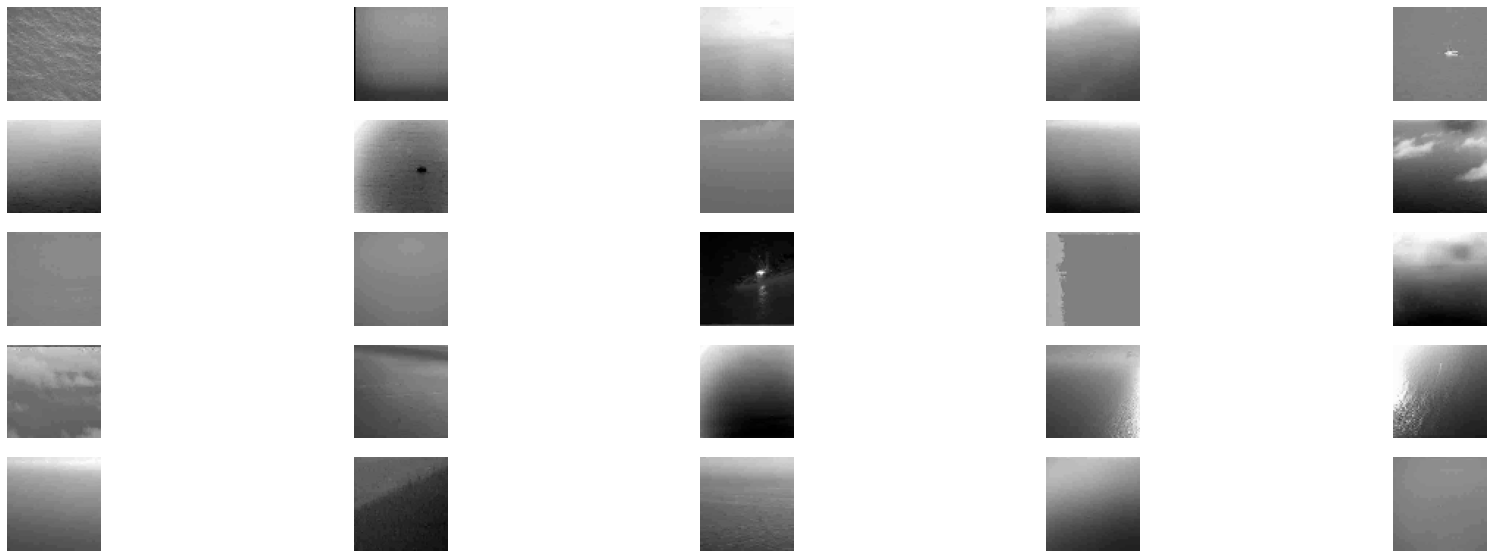

In [ ]:
plt.figure(figsize=(30, 10))
for i in range(75, 100):
    ax = plt.subplot(5, 5, i -75 + 1)
    plt.imshow(images[idx_cluster_1[i]].numpy().astype('int'))
    plt.axis("off")

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_output =confusion_matrix(k_vgg19_pred_pca, k_resnet50_pred_pca)

In [ ]:
confusion_matrix_output

array([[2670, 1722],
       [ 852, 4756]])

Final labels of the pictures

In [ ]:
final_labels = [(k_vgg19_pred_pca[i] == 1 and k_resnet50_pred_pca[1] == 1) for i in range(len(k_resnet50_pred_pca))]
final_labels = np.array(final_labels)
print(len(final_labels))

10000


In [ ]:
import pickle
with open('labels.pkl', 'wb') as f:
  pickle.dump(list(final_labels), f)

In [ ]:
final_labels = np.array(pickle.load(open("labels.pkl", "rb")))

## Building an Image Classifier
Now that we have clustered the images and gotten labels of the images from the clusters that they're in, we can now look to build an image classification model that can identify whether the image is of the ocean and skyline, or whether it contains a boat in the sea. To do this, we take the labels from before as well as the images.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3

In [ ]:
images.shape

TensorShape([10000, 64, 64, 3])

In [ ]:
x_train = images[:int(images.shape[0]*0.8)]
x_test = images[int(images.shape[0]*0.8):]
x_train = x_train/ 255.0
x_test = x_test/ 255.0
y_train = final_labels[:int(images.shape[0]*0.8)]
y_test = final_labels[int(images.shape[0]*0.8):]

#### Baseline Model

In [ ]:
input = keras.Input(shape=(64,64,3))
h = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(input)
h = keras.layers.MaxPool2D()(h)
h = keras.layers.Conv2D(64, kernel_size=(2, 2), activation="relu", name="Conv_2")(h) 
h = keras.layers.MaxPool2D()(h)
h = keras.layers.Dropout(0.2)(h)
h = keras.layers.Flatten()(h)
h = keras.layers.Dense(64, activation="relu")(h)

output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)
model = keras.Model(input, output)

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 Conv_1 (Conv2D)             (None, 63, 63, 32)        416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 Conv_2 (Conv2D)             (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0   

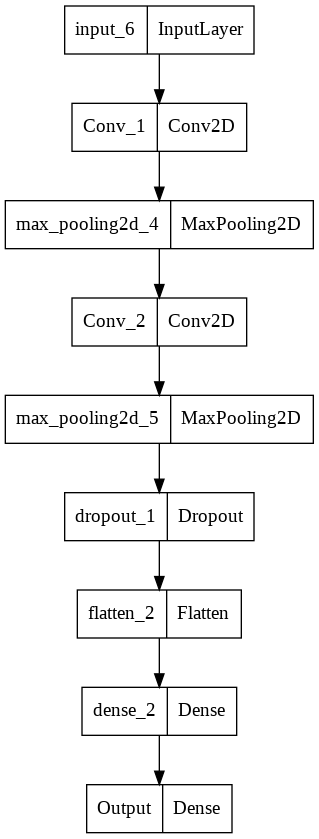

In [ ]:
keras.utils.plot_model(model)

In [ ]:
batch_size = 32
epochs = 30

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 0.4429 - accuracy: 0.8015
Epoch 2/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3997 - accuracy: 0.8238
Epoch 3/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3851 - accuracy: 0.8363
Epoch 4/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3721 - accuracy: 0.8361
Epoch 5/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3610 - accuracy: 0.8419
Epoch 6/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3507 - accuracy: 0.8450
Epoch 7/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8496
Epoch 8/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3211 - accuracy: 0.8574
Epoch 9/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3092 - accuracy: 0.8648
Epoch 10/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3025 - accuracy: 0.8698

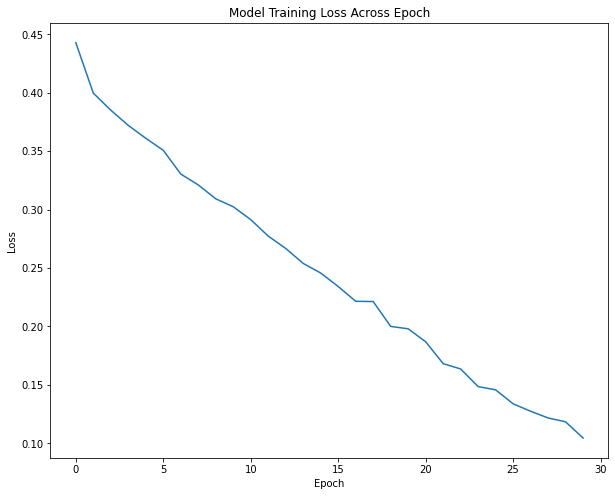

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Model Training Loss Across Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(history.history["loss"])

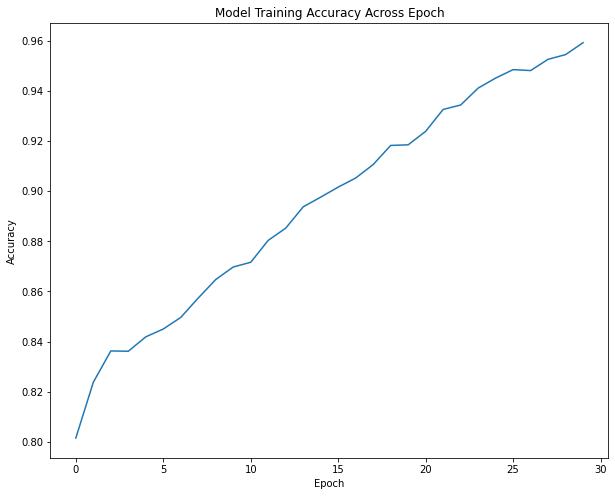

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Model Training Accuracy Across Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(history.history["accuracy"])

In [ ]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.5515 - accuracy: 0.8680


[0.551494300365448, 0.8679999709129333]

#### Transfer Learning with ResNet50

In [ ]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(64, 64, 3))

resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
x = resnet50_base.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet50_base.input, outputs=x)

In [ ]:
# freeze pretrained layers during initial training
for layer in model.layers:
    layer.trainable = False
  
for layer in model.layers[-30:]:
    layer.trainable = True

In [ ]:
model.compile(loss="binary_crossentropy",     #  loss=spec_loss,
              optimizer="adam", 
              metrics=["accuracy"])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(x_train, y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 9s 50ms/step - loss: 0.5813 - accuracy: 0.7883 - val_loss: 1.3207 - val_accuracy: 0.5700
Epoch 2/20
100/100 [==============================] - 4s 41ms/step - loss: 0.3986 - accuracy: 0.8308 - val_loss: 0.9353 - val_accuracy: 0.5038
Epoch 3/20
100/100 [==============================] - 4s 40ms/step - loss: 0.3632 - accuracy: 0.8419 - val_loss: 1.8314 - val_accuracy: 0.4694
Epoch 4/20
100/100 [==============================] - 4s 40ms/step - loss: 0.3528 - accuracy: 0.8486 - val_loss: 0.6194 - val_accuracy: 0.6231
Epoch 5/20
100/100 [==============================] - 4s 41ms/step - loss: 0.3501 - accuracy: 0.8461 - val_loss: 1.1159 - val_accuracy: 0.6606
Epoch 6/20
100/100 [==============================] - 4s 41ms/step - loss: 0.3317 - accuracy: 0.8572 - val_loss: 0.5404 - val_accuracy: 0.6538
Epoch 7/20
100/100 [==============================] - 4s 41ms/step - loss: 0.3413 - accuracy: 0.8542 - val_loss: 1.6798 - val_accuracy: 0.5050

In [ ]:
# unfreeze pretrained layers during second round of training
for layer in model.layers:
    layer.trainable = True

In [ ]:
history_2 = model.fit(x_train, y_train,
                      shuffle=True,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS//2,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/10
100/100 [==============================] - 5s 54ms/step - loss: 0.2763 - accuracy: 0.8734 - val_loss: 0.5194 - val_accuracy: 0.6725
Epoch 2/10
100/100 [==============================] - 5s 53ms/step - loss: 0.2759 - accuracy: 0.8766 - val_loss: 1.5301 - val_accuracy: 0.5219
Epoch 3/10
100/100 [==============================] - 4s 45ms/step - loss: 0.2744 - accuracy: 0.8758 - val_loss: 0.5140 - val_accuracy: 0.8581
Epoch 4/10
100/100 [==============================] - 4s 42ms/step - loss: 0.2816 - accuracy: 0.8753 - val_loss: 1.0597 - val_accuracy: 0.5550
Epoch 5/10
100/100 [==============================] - 4s 42ms/step - loss: 0.2779 - accuracy: 0.8737 - val_loss: 2.6250 - val_accuracy: 0.5537
Epoch 6/10
100/100 [==============================] - 4s 42ms/step - loss: 0.2749 - accuracy: 0.8772 - val_loss: 0.4719 - val_accuracy: 0.7387
Epoch 7/10
100/100 [==============================] - 4s 42ms/step - loss: 0.2794 - accuracy: 0.8756 - val_loss: 7.6974 - val_accuracy: 0.4425

In [ ]:
model.evaluate(x_test, y_test)

63/63 [==============================] - 2s 20ms/step - loss: 0.4464 - accuracy: 0.8590


[0.4464234709739685, 0.859000027179718]

In [ ]:
predictions = model.predict(x_test).argmax(axis=-1)
predictions = predictions.reshape(1, -1)[0]
cm = confusion_matrix(y_test, predictions)
cm

array([[ 846,    0],
       [1154,    0]])

In [ ]:
model.save('model.h5')